In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import glob
import pickle

from moviepy.editor import VideoFileClip
from IPython.display import HTML


def calibrate_undist(original_img, nx=9, ny=6, draw=False, return_mtx=False):
    """
    Apply calibration and undistortion using jpeg images in ./camera_cal
    """
    images = glob.glob('./camera_cal/calibration*.jpg')
    objp = np.zeros((nx * ny, 3), dtype=np.float32)
    objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
    objpoints = []    # 3d points in real world space
    imgpoints = [] # 2d points in image plane

    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)            # Find the chessboard corners
        if ret == True:                                                                                           # If found, add object points, image points
            objpoints.append(objp)
            imgpoints.append(corners)

    img_size = original_img.shape[:2]
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    dst = undistort(original_img, mtx, dist, draw=draw)
    if return_mtx:
        return dst, mtx, dist
    else:
        return dst
    
def undistort(img, mtx, dist, draw=False):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    if draw:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=30)
        ax2.imshow(dst)
        ax2.set_title('Undistorted Image', fontsize=30)
    return dst    

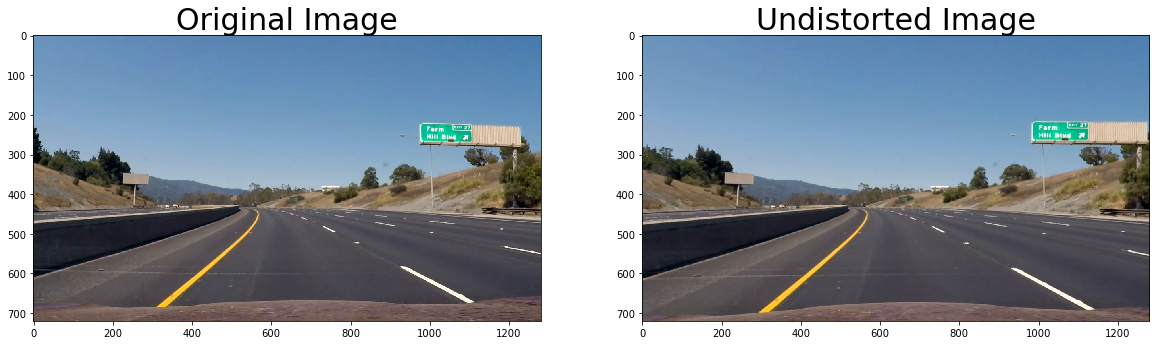

In [2]:
# Undistort a test image from challenge_video.mp4

clip = VideoFileClip("./project_video.mp4")
img = clip.get_frame(1.7)[:, :, -1::-1]
test_img_name = './examples/undistort_test.png'

dst, mtx, dist = calibrate_undist(img, draw=True, return_mtx=True)
cv2.imwrite(test_img_name, dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "./wide_dist_pickle.p", "wb" ) )


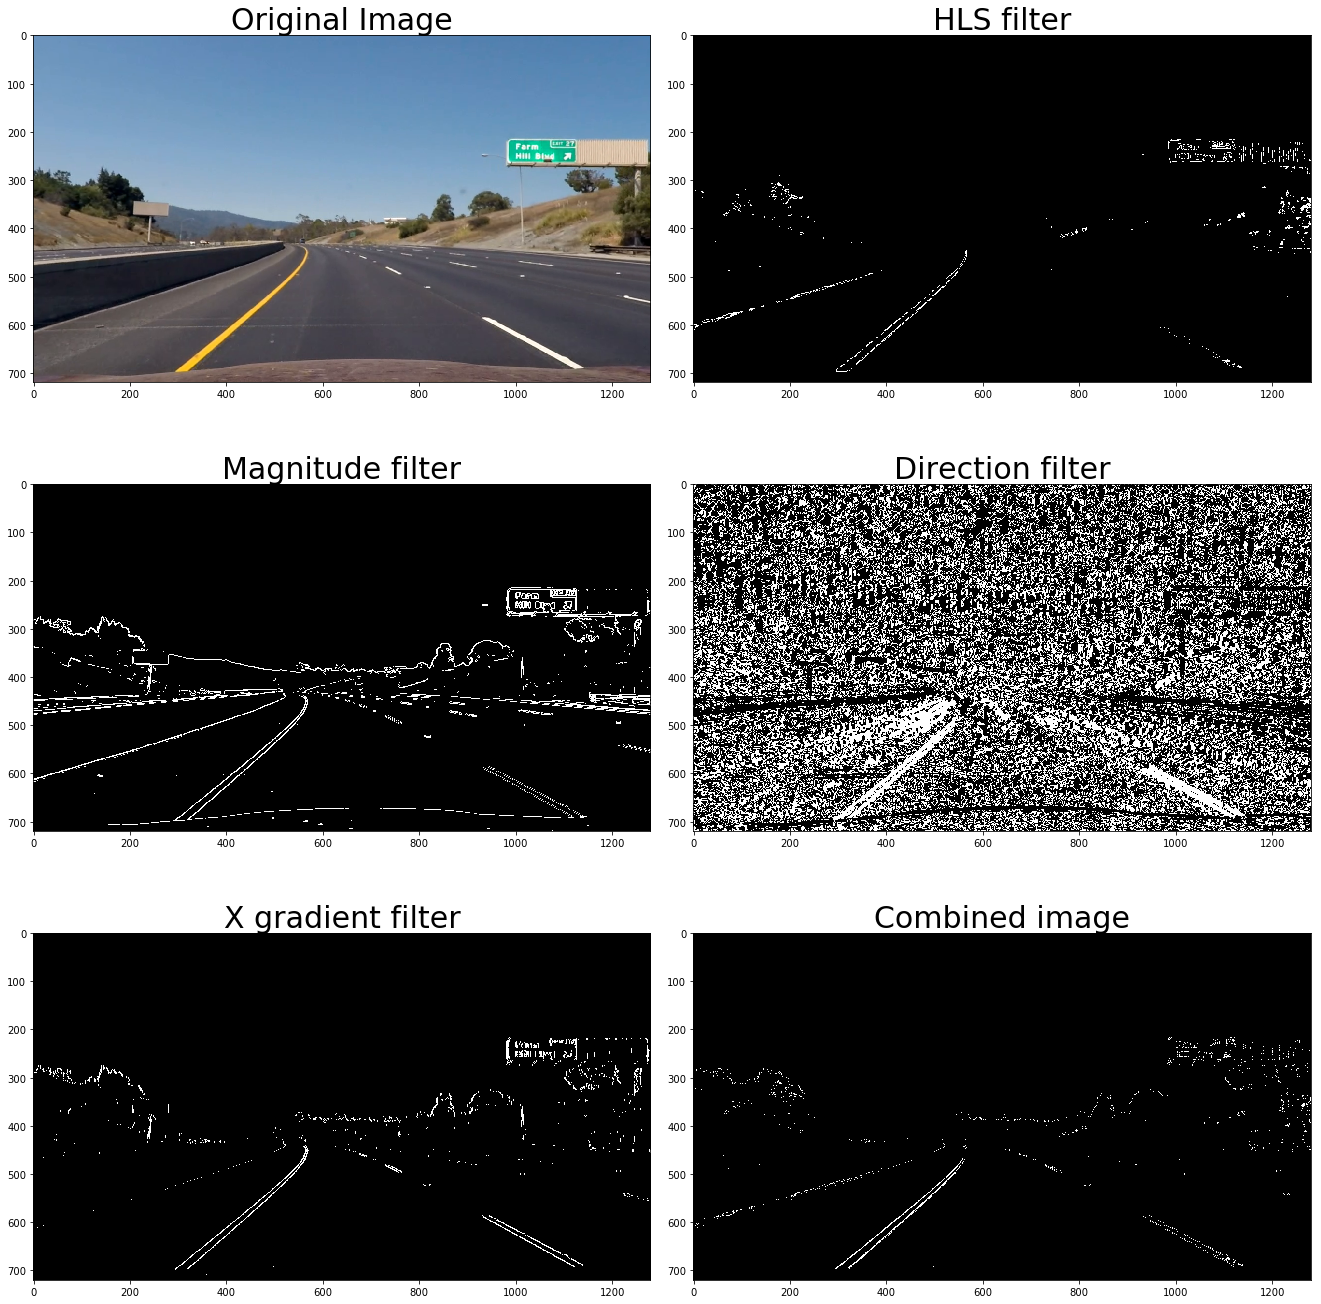

In [3]:
### Functions to make binary image

def abs_sobel_thresh(img, orient='x', sobel_kernel = 3, thresh=(0, 255)):
    """
    Applying Sobel.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)*255
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    """
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)*255
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    abs_sobelx = np.abs(sobelx)
    abs_sobely = np.abs(sobely)
    direction = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(direction)
    dir_binary[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    return dir_binary

def hls_select(img, channel = 2, thresh=(0, 255)):
    """
    """
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    C = hls[:,:,channel]*255
    binary = np.zeros_like(C)
    binary[(C > thresh[0]) & (C <= thresh[1])] = 1
    return binary

def mag_threshold(img, sobel_kernel=3, mag_thresh=(0, 255)):
    """
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)*255
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    abs_sobel = np.sqrt(np.square(sobelx)+np.square(sobely))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1 
    return binary_output


#Binary transformation
def binary_transform(image, 
                     sobel_kernel=3, sobel_thresh=(50, 150), 
                     mag_thresh=(50, 150), 
                     channel=2, hls_thresh=(120, 180), 
                     dir_thresh=(0.7, 1.3), 
                     draw=False):        

    x_binary = abs_sobel_thresh(image, orient='x', sobel_kernel=sobel_kernel, thresh=sobel_thresh)
    y_binary = abs_sobel_thresh(image, orient='y', sobel_kernel=sobel_kernel, thresh=sobel_thresh)
    mag_binary = mag_threshold(image, sobel_kernel=sobel_kernel, mag_thresh=mag_thresh)
    hls_binary = hls_select(image, channel=channel, thresh=hls_thresh)
    dir_binary = dir_threshold(image, sobel_kernel=15, thresh=dir_thresh)
    combined = np.zeros_like(mag_binary)
    combined[ ((hls_binary == 1) & (dir_binary==1))|( (mag_binary == 1) & (x_binary==1) & (y_binary == 1))] = 1
    if draw:
        f, ((ax1, ax2),( ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(18, 12))
        f.tight_layout()
        ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image', fontsize=30)
        ax2.imshow(hls_binary, cmap='gray')
        ax2.set_title('HLS filter', fontsize=30)
        ax3.imshow(mag_binary, cmap='gray')
        ax3.set_title('Magnitude filter', fontsize=30)
        ax4.imshow(dir_binary, cmap='gray')
        ax4.set_title('Direction filter', fontsize=30)
        ax5.imshow(x_binary, cmap='gray')
        ax5.set_title('X gradient filter', fontsize=30)
        ax6.imshow(combined, cmap='gray')
        ax6.set_title('Combined image', fontsize=30)
        plt.subplots_adjust(left=0., right=None, top=1.5, bottom=0.)
    return combined


### Make and plot binary image
image = mpimg.imread(test_img_name)

combined = binary_transform(image, draw=True)

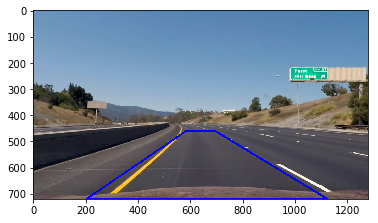

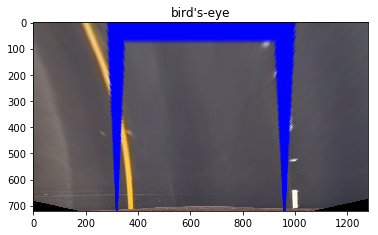

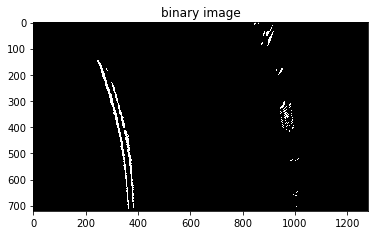

In [4]:
### Transform it to bird's-eye

def warp(img, inverse = False):    
    img_size = (img.shape[1],img.shape[0])
    src = np.float32(
        [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])
    if inverse == False:
        M = cv2.getPerspectiveTransform(src, dst)
    elif inverse == True:
        M = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped


img = cv2.imread(test_img_name)
img_size = (img.shape[1], img.shape[0])

src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])

LINE_WIDTH = 6
img = cv2.line(img, (src[0][0],src[0][1]),(src[1][0],src[1][1]),(0,0,255), LINE_WIDTH)
img = cv2.line(img, (src[1][0],src[1][1]),(src[2][0],src[2][1]),(0,0,255), LINE_WIDTH)
img = cv2.line(img, (src[2][0],src[2][1]),(src[3][0],src[3][1]),(0,0,255), LINE_WIDTH)
img = cv2.line(img, (src[3][0],src[3][1]),(src[0][0],src[0][1]),(0,0,255), LINE_WIDTH)
# img = cv2.cvtColor (img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

plt.figure()
warped = warp(img)
plt.imshow(warped)
plt.title("bird's-eye")

plt.figure()
warped = warp(combined)
plt.imshow(warped, cmap = 'gray')
plt.title("binary image")


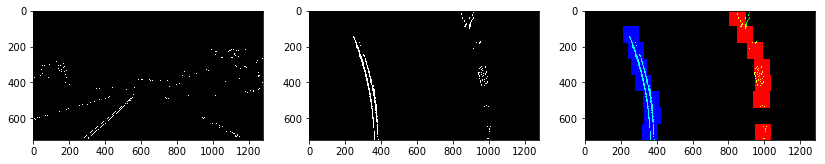

In [5]:
#Finding peaks in histgram for gredients
def find_peak(histogram):
    first_peak = np.argmax(histogram)
    if (first_peak - 300) >= 0:
        histogram[first_peak-300:first_peak+300] = 0
    else:
        histogram[:first_peak+300] = 0
        histogram[(len(histogram)- first_peak + 300):] = 0
    second_peak = np.argmax(histogram)
    left_peak, right_peak = np.sort([first_peak, second_peak])
    return left_peak, right_peak

#Finding square box, which is likely to include lane pixels
def find_lane(img):
    left_blue = np.zeros_like(img)
    right_red = np.zeros_like(img)
    histogram = np.sum(img[img.shape[0]/2:,:], axis=0)
    first_left, first_right = find_peak(histogram)
    length = img.shape[0]/8
    img_size = (img.shape[1], img.shape[0])
    left_blue = cv2.rectangle(left_blue, (int(first_left-length/2), img_size[1]- 90),
                              (int(first_left+length/2),img_size[1]), 1, -1)
    right_red = cv2.rectangle(right_red, (int(first_right-length/2), img_size[1]- 90),
                              (int(first_right+length/2),img_size[1]), 1, -1)
    
    pre_left, pre_right = first_left, first_right
    
    for i in range(7):
        if i != 6:
            histogram = np.sum(img[img.shape[0]*(8-i-2)/8:img.shape[0]*(8-i-1)/8,:], axis=0)
        else:
            histogram = np.sum(img[0:img.shape[0]*(8-i-1)/8,:], axis=0)
        biggest, second_biggest = find_peak(histogram)
        if ((biggest > (pre_left - length*4/3)) & (biggest < (pre_left + length*4/3))):
            left = biggest
            left_blue = cv2.rectangle(left_blue, (int(left-length/2), img_size[1]- 90*(i+2)),
                          (int(left+length/2),img_size[1]-90*(i+1)), 1, -1)
            pre_left = left
        elif ((second_biggest > (pre_left - length*4/3)) & (second_biggest < (pre_left + length*4/3))):
            left = second_biggest
            left_blue = cv2.rectangle(left_blue, (int(left-length/2), img_size[1]- 90*(i+2)),
                          (int(left+length/2),img_size[1]-90*(i+1)), 1, -1)
            pre_left = left
        if (biggest > (pre_right - length*4/3)) & (biggest < (pre_right + length*4/3)):
            right = biggest
            right_red = cv2.rectangle(right_red, (int(right-length/2), img_size[1]- 90*(i+2)),
                          (int(right+length/2),img_size[1]-90*(i+1)), 1, -1)
            pre_right = right
        elif (second_biggest > (pre_right - length*4/3)) & (second_biggest < (pre_right + length*4/3)):
            right = second_biggest
            right_red = cv2.rectangle(right_red, (int(right-length/2), img_size[1]- 90*(i+2)),
                          (int(right+length/2),img_size[1]-90*(i+1)), 1, -1)
            pre_right = right
    color_binary = np.dstack((right_red, img, left_blue))
    return color_binary, right_red, img, left_blue      
        
timg = plt.imread(test_img_name)
timg = undistort(timg, mtx, dist)
timg = binary_transform(timg)
fig = plt.figure(figsize=(14,5))
plt.subplot(131)
plt.imshow(timg, cmap = 'gray')
warped_timg = warp(timg)
plt.subplot(132)
plt.imshow(warped_timg, cmap = 'gray')
t_lanes, right, binary, left= find_lane(warped_timg)
plt.subplot(133)
plt.imshow(t_lanes*255)


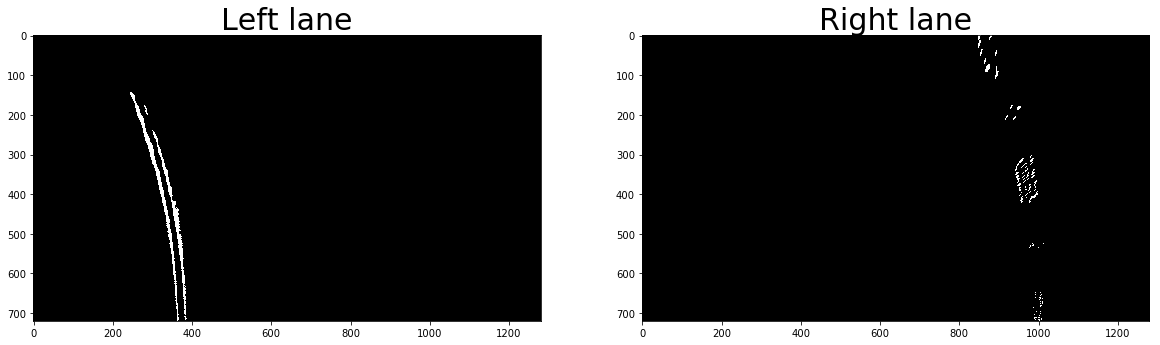

In [6]:
#Visualise each lane pixels

combined_left = np.zeros_like(binary)
combined_right = np.zeros_like(binary)
combined_left[(binary == 1) & (left == 1)] = 1
combined_right[(binary == 1) & (right == 1)] = 1

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(combined_left*255, cmap = 'gray')
ax1.set_title('Left lane', fontsize=30)
ax2.imshow(combined_right*255, cmap = 'gray')
ax2.set_title('Right lane', fontsize=30)

In [7]:
#input is 1d binary image
def making_points_list(img):
    height = img.shape[0]
    width = img.shape[1]
    y = []
    x = []
    for i in range(height):
        for j in range(width):
            if img[i][j] == 1:
                y.append(i)
                x.append(j)
    x = np.asarray(x)
    y = np.asarray(y)
    return x, y

#measuring curvanture
def measuring_curv(l_x, l_y, r_x, r_y):
    l_max = 720
    r_max = 720
    ym_per_pix = 30./720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension

    left_fit_cr = np.polyfit(l_y * ym_per_pix, l_x * xm_per_pix, 2)
    right_fit_cr = np.polyfit(r_y * ym_per_pix, r_x * xm_per_pix, 2)
    left_curverad = ((1 + (2 * left_fit_cr[0] * l_max + left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * left_fit_cr[0])
    right_curverad = ((1 + (2 * right_fit_cr[0] * r_max + right_fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * right_fit_cr[0])
    average_curv = (left_curverad + right_curverad)/2
    return average_curv

#adding necessary infomation on an image
def get_text_info(img, l_x, l_y, r_x, r_y, l_lane_pix, r_lane_pix):
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    screen_middel_pixel = img.shape[1] / 2
    car_middle_pixel = int((r_lane_pix + l_lane_pix)/2)
    screen_off_center = screen_middel_pixel - car_middle_pixel
    meters_off_center = round(xm_per_pix * screen_off_center, 2)
    curv_in_meters = int(measuring_curv(l_x, l_y, r_x, r_y))
    return meters_off_center, curv_in_meters
    

#calculating polyfit and r squared
def polyfit(x, y, degree):
    results = {}
    coeffs = np.polyfit(x, y, degree)
     # Polynomial Coefficients
    results['polynomial'] = coeffs.tolist()

    # r-squared
    p = np.poly1d(coeffs)
    # fit values, and mean
    yhat = p(x)                         # or [p(z) for z in x]
    ybar = np.sum(y)/len(y)          # or sum(y)/len(y)
    ssreg = np.sum((yhat-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
    sstot = np.sum((y - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
    results['determination'] = round(ssreg / sstot, 3)

    return results

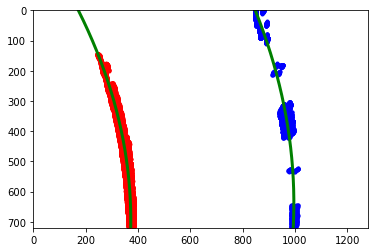

In [8]:
left_x, left_y = making_points_list(combined_left)
right_x, right_y = making_points_list(combined_right)

l_results = polyfit(left_y, left_x, 2)
left_fit = l_results['polynomial']
ly_vals = np.linspace(0, 100, num=len(left_x))*7.2
left_fitx = left_fit[0]*ly_vals**2 + left_fit[1]*ly_vals + left_fit[2]

r_results = polyfit(right_y, right_x, 2)
right_fit = r_results['polynomial']
ry_vals = np.linspace(0, 100, num=len(right_x))*7.2
right_fitx = right_fit[0]*ry_vals**2 + right_fit[1]*ry_vals + right_fit[2]

# avg_curverad, left_curverad, right_curverad = measuring_curv(left_fitx, ly_vals, right_fitx, ry_vals)
# avg_curverad = measuring_curv(left_x, ly_vals, right_x, ry_vals)

off_center, avg_curverad = get_text_info(img, left_x, ly_vals, right_x, ry_vals, left_fitx[-1], right_fitx[-1])

plt.plot(left_x, left_y, '.', color='red')
plt.plot(right_x, right_y, '.', color='blue')
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ly_vals, color='green', linewidth=3)
plt.plot(right_fitx, ry_vals, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

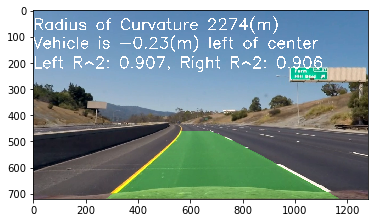

In [9]:
undist = cv2.imread(test_img_name)

warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ly_vals]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ry_vals])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = warp(color_warp, inverse = True)
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
off_center, avg_curved = get_text_info(result, left_x, ly_vals, right_x, ry_vals, left_fitx[-1], right_fitx[-1])

font = cv2.FONT_HERSHEY_SIMPLEX
result = cv2.putText(result,'Radius of Curvature %d(m)' %avg_curverad,(0,75), font, 2,(255,255,255),4)
result = cv2.putText(result,'Vehicle is {}(m) left of center'.format(off_center) ,(0,145), 
                     font, 2,(255,255,255),4)
result = cv2.putText(result,'Left R^2: {}, Right R^2: {}'.format(l_results['determination'], 
                                r_results['determination']),(0,220), font, 2,(255,255,255),4)


plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

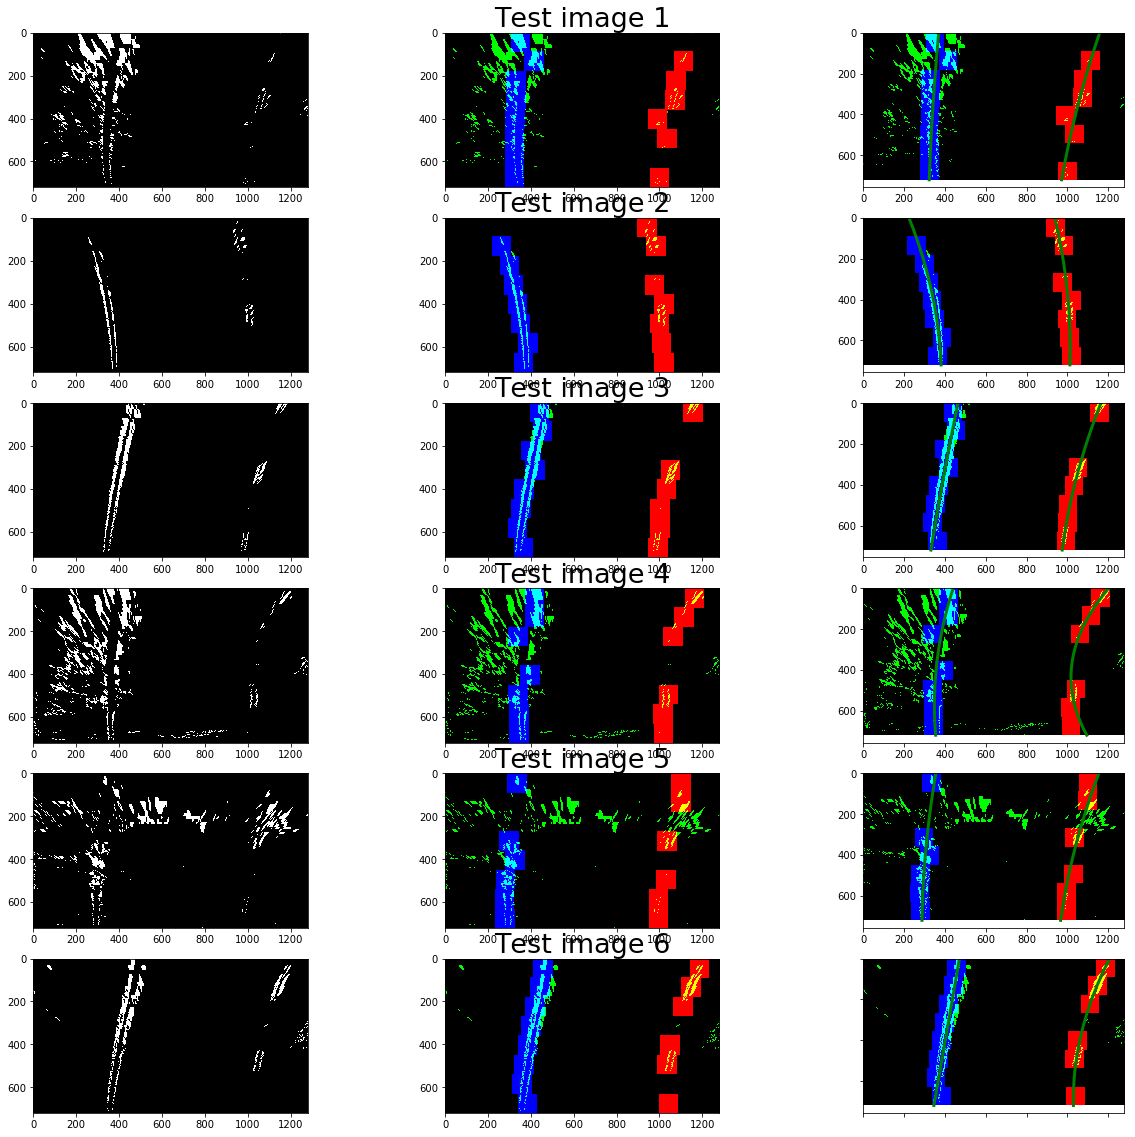

In [10]:
def drawing_from_bird(binary):
    warped_binary = warp(binary)
    lanes, right, binary, left= find_lane(warped_binary)
    
    #making points for bith sides
    combined_left = np.zeros_like(binary)
    combined_right = np.zeros_like(binary)
    combined_left[(binary == 1) & (left == 1)] = 1
    combined_right[(binary == 1) & (right == 1)] = 1
    left_x, left_y = making_points_list(combined_left)
    right_x, right_y = making_points_list(combined_right)
    
    #fitting left lane
    left_fit = np.polyfit(left_y, left_x, 2)
    ly_vals = np.linspace(0, 100, num=len(left_x))*7.2
    left_fitx = left_fit[0]*ly_vals**2 + left_fit[1]*ly_vals + left_fit[2]
    #fitting right lane
    right_fit = np.polyfit(right_y, right_x, 2)
    ry_vals = np.linspace(0, 100, num=len(right_x))*7.2
    right_fitx = right_fit[0]*ry_vals**2 + right_fit[1]*ry_vals + right_fit[2]
    return ly_vals, left_fitx, ry_vals, right_fitx

#Visualising test images
test_images = np.sort(glob.glob('test_images/test*.jpg'))
f, Ax = plt.subplots(len(test_images), 3, figsize=(18, 10))
plt.tick_params(labelbottom='off')
plt.tick_params(labelleft='off')
plt.subplots_adjust(left=0., right=None, top=1.5, bottom=0.)

for i in range(len(test_images)):
    t_img = mpimg.imread(test_images[i])
    idx = Ax[i, 0]
    bi_pic = binary_transform(t_img)
    warped = warp(bi_pic)
    idx.imshow(warped, cmap = 'gray')
        
    lanes, right, binary, left= find_lane(warped)
    idx = Ax[i, 1]
    idx.imshow(lanes*255)
    idx.set_title("Test image %d" %(i+1) , fontsize=27)
    
    ly_vals, left_fitx, ry_vals, right_fitx = drawing_from_bird(bi_pic)
    warped = warp(bi_pic)
    lanes, right, binary, left= find_lane(warped)
    idx = Ax[i, 2]
    idx.imshow(lanes*255)
    idx.plot(left_fitx, ly_vals, color='green', linewidth=3)
    idx.plot(right_fitx, ry_vals, color='green', linewidth=3)


In [52]:
def draw_output(img, binary):
    warped_binary = warp(binary)
    lanes, right, binary, left= find_lane(warped_binary)
    
    #making points for both sides
    combined_left = np.zeros_like(binary)
    combined_right = np.zeros_like(binary)
    combined_left[(binary == 1) & (left == 1)] = 1
    combined_right[(binary == 1) & (right == 1)] = 1
    left_x, left_y = making_points_list(combined_left)
    right_x, right_y = making_points_list(combined_right)
    
    #Fitting with polynomials
    l_results = polyfit(left_y, left_x, 2)
    left_fit = l_results['polynomial']
    ly_vals = np.linspace(0, 100, num=len(left_x)) * 7.2
    left_fitx = left_fit[0] * ly_vals ** 2 + left_fit[1] * ly_vals + left_fit[2]
    r_results = polyfit(right_y, right_x, 2)
    right_fit = r_results['polynomial']
    ry_vals = np.linspace(0, 100, num=len(right_x))*7.2
    right_fitx = right_fit[0]*ry_vals**2 + right_fit[1]*ry_vals + right_fit[2]
    
    #preparing color pre-warp image 
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    #Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ly_vals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ry_vals])))])
    pts = np.hstack((pts_left, pts_right))

    #Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    #Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = warp(color_warp, inverse = True)
    
    #Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    #Get necessary text info
    off_center, avg_curverad = get_text_info(result, left_x, ly_vals, right_x, ry_vals, 
                                             left_fitx[-1], right_fitx[-1])

    font = cv2.FONT_HERSHEY_SIMPLEX
    result = cv2.putText(result,'Radius of Curvature %d(m)' %avg_curverad,(0, 75), font, 2, (255, 255, 255), 4)
    result = cv2.putText(result,'Vehicle is {}(m) left of center'.format(off_center), (0, 145), 
                 font, 2, (255, 255, 255), 4)
    result = cv2.putText(result,'Left R^2: {}, Right R^2: {}'.format(l_results['determination'], 
                                r_results['determination']), (0, 220), font, 2, (255, 255, 255), 4)
    return result

def pipeline(img):
    image = calibrate_undist(img)
    combined_binary = binary_transform(image)
    result = draw_output(image, combined_binary)
    return result

test1_output = 'test1.mp4'
clip1 = VideoFileClip("project_video.mp4")
test1_clip = clip1.fl_image(pipeline)
%time test1_clip.write_videofile(test1_output, audio=False)


[MoviePy] >>>> Building video test1.mp4
[MoviePy] Writing video test1.mp4


100%|█████████▉| 1260/1261 [11:11:45<00:08,  8.79s/it]     1261 [00:09<3:15:14,  9.30s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test1.mp4 

CPU times: user 3h 17min, sys: 4min 23s, total: 3h 21min 24s
Wall time: 11h 11min 46s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test1_output))